# Import libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test

import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Import data

In [2]:
mas_dat = pd.read_excel("mas_dat.xlsx")

mas_dat['UID'] = mas_dat['UID'].astype(str).str.zfill(9)
mas_dat['Dept_code'] = mas_dat['Dept_code'].astype(str).str.zfill(4)

print("Master's programs: N =",
     len(mas_dat['UID'].unique()))

Master's programs: N = 55439


# Remove potential SIR

In [3]:
mas_dat = mas_dat.groupby('UID').filter(
    lambda x: not (len(x) == 1 and (x['GPA'] == 0).all())
)

print("Exclude potential summer-melt students who only had one row of record: N =",
     len(mas_dat['UID'].unique()))

Exclude potential summer-melt students who only had one row of record: N = 54491


# Fix associated majors & keep students with one degree

In [22]:
associated_majors = pd.read_excel("Associated Majors.xlsx").dropna().sort_values(by='Associated Major Group')

# Create a lookup table with the standard major code and name for each associated major group
standard_majors = associated_majors.groupby('Associated Major Group').agg(
    Standard_Major_Code=('Major Code', 'last'),
    Standard_Major_Name=('Major Name', 'last')
).reset_index()

# Join the data frame `mas_dat` with the associated_majors
mas_dat2 = pd.merge(mas_dat, associated_majors, left_on='Dept_code', right_on='Major Code', how='left')
mas_dat2 = pd.merge(mas_dat2, standard_majors, on='Associated Major Group', how='left')

# Replace Major_Code and Major_Name with the coalesced values
mas_dat2['Major_Code'] = mas_dat2['Standard_Major_Code'].combine_first(mas_dat2['Dept_code'])
mas_dat2['Major_Name'] = mas_dat2['Standard_Major_Name'].combine_first(mas_dat2['Dept'])

# Select specific columns
mas_dat2 = mas_dat2.iloc[:, list(range(2)) + [18, 19] + list(range(4, 13))]

# Rename columns
mas_dat2.columns.values[2] = 'Dept_code'
mas_dat2.columns.values[3] = 'Dept'


# Find students with only one degree
num_dept = mas_dat2.groupby('UID')['Dept_code'].nunique().reset_index()
sgl_depts_UID = num_dept[num_dept['Dept_code'] == 1]['UID']

# Filter for single department
mas_dat2 = mas_dat2[ (mas_dat2['UID'].isin(sgl_depts_UID)) & (mas_dat2['Dept_code'] != '0001') ]

# Exclude students who mastered out from a PhD program
mas_dat2 = mas_dat2[~mas_dat2['UID'].isin(['403133806', '903535472'])]

print('Pursue only one degree: N =',
     len(mas_dat2['UID'].unique()))


Pursue only one degree: N = 53263


# Fix different ADMIT_TERM

## Add accurate data

In [11]:
# Find accurate ADMIT_TERM from accurate database
mas_accurate = pd.read_excel("Mas_Accurate.xlsx")
mas_accurate['UID'] = mas_accurate['UID'].astype(str).str.zfill(9)
mas_accurate['Dept_code'] = mas_accurate['Dept_code'].astype(str).str.zfill(4)

## Merging data
mas_accurate = pd.merge(mas_accurate, associated_majors, left_on='Dept_code', right_on='Major Code', how='left')
mas_accurate = pd.merge(mas_accurate, standard_majors, on='Associated Major Group', how='left')

## Combining and reordering columns
mas_accurate['Major_Code'] = mas_accurate['Standard_Major_Code'].combine_first(mas_accurate['Dept_code'])
mas_accurate = mas_accurate.iloc[:, [0, 9] + [2, 3]]
mas_accurate.columns.values[1] = 'Dept_code'


## Custom sort function
def custom_sort(term):
    term = str(term)  # Ensure term is a string
    year = int(term[1:])  # Extract the year (numeric part)
    term_order = {'W': 0, 'S': 1, 'F': 2, 'X': 3}  # Define the order of the term type
    term_type_order = term_order.get(term[0], 999)  # Get the order index for the term type
    return (year, term_type_order)  # Return a tuple with year first, then term type order

## Clean conflicting DEG_TERMs and ADMIT_TERMs for each student
def process_group(group):
    group = group.sort_values(by='ADMIT_TERM', key=lambda x: x.map(custom_sort))
    
    deg_term_non_na = group['DEG_TERM'].dropna()
    
    if group['DEG_TERM'].isna().sum() > 0:            # Have NA DEG_TERMs
        if not deg_term_non_na.empty:                   # Include at least one non-NA DEG_TERM (Same major name changed)
            admit_term = group['ADMIT_TERM'].iloc[0]       # Earliest ADMIT_TERM
            deg_term = deg_term_non_na.iloc[-1]              # Latest non-NA DEG_TERM
        else:                                           # All NAs: just take first pair
            admit_term = group['ADMIT_TERM'].iloc[0] 
            deg_term = group['DEG_TERM'].iloc[0]
    elif group['DEG_TERM'].isna().sum() == 0:         # Have 2 non-NA DEG_TERMs (2 degrees)
        if group['Dept_code'].iloc[0] == '0249':        # Just consider the 1st degree
            admit_term = group['ADMIT_TERM'].iloc[0]  
            deg_term = group['DEG_TERM'].iloc[0]            
        else:                                         # Lasted for that long
            admit_term = group['ADMIT_TERM'].iloc[0]        # First ADMIT_TERM
            deg_term = group['DEG_TERM'].iloc[-1]           # Last DEG_TERM
    
    group['ADMIT_TERM'] = admit_term
    group['DEG_TERM'] = deg_term
    return group

mas_accurate = mas_accurate.groupby(['UID', 'Dept_code']).apply(process_group).reset_index(drop=True)

## Fill Term NAs with non-NaN value for each student
def fill_term_nans(group):
    group['ADMIT_TERM'] = group.groupby('UID')['ADMIT_TERM'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    group['DEG_TERM'] = group.groupby('UID')['DEG_TERM'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    return group

mas_accurate = mas_accurate.groupby(['UID', 'Dept_code']).apply(fill_term_nans).reset_index(drop=True)


# Update summer terms
def replace_first_char(term):
    if pd.isna(term):  # Check if the term is NaN
        return term
    term = str(term)  # Ensure the term is treated as a string
    if term[0] in ['1', '2']:
        return 'X' + term[1:]
    return term

mas_accurate['ADMIT_TERM'] = mas_accurate['ADMIT_TERM'].apply(replace_first_char)
mas_accurate['DEG_TERM'] = mas_accurate['DEG_TERM'].apply(replace_first_char)


## If mas_dat2 included in mas_accurate

In [34]:
in_mas_accurate = pd.merge(mas_dat2, mas_accurate, on=['UID', 'Dept_code'])

### If ADMIT_TERM_y = any ADMIT_TERM_x

In [35]:
xy_admit_match = in_mas_accurate[in_mas_accurate['ADMIT_TERM_x'] == in_mas_accurate['ADMIT_TERM_y']]

# Choose first-year info
xy_admit_match = (xy_admit_match
                  .groupby('UID', group_keys=False)  # Group by UID
                  .apply(lambda x: x.sort_values(by='ENR_TERM', key=lambda col: col.map(custom_sort))))
xy_admit_match_chosen_admit_info = xy_admit_match.drop_duplicates(subset='UID', keep='first')[['UID', 'st_required', 'prev_deg', 'TIME_DEG', 'URM', 'Non_Male', 'STEM', 'ADMIT_TERM_y', 'DEG_TERM_y']]
xy_admit_match_chosen_admit_info.columns = [col.replace('_y', '') for col in xy_admit_match_chosen_admit_info.columns]

# Add into complete xy_admit_match
xy_admit_match = pd.merge(xy_admit_match, xy_admit_match_chosen_admit_info, how = 'left', on = ['UID'], suffixes=('', '_chosen'))

# Clean
required_columns = ['UID', 'Dept_code', 'Dept', 'ENR_TERM', 'GPA', 'ADMIT_TERM', 'DEG_TERM']
chosen_columns = [col for col in xy_admit_match.columns if col.endswith('_chosen')]
all_columns = required_columns + chosen_columns
xy_admit_match = xy_admit_match[all_columns]
xy_admit_match.columns = [col.replace('_chosen', '') for col in xy_admit_match.columns]
xy_admit_match = xy_admit_match.reindex(sorted(xy_admit_match.columns), axis=1)


### If ADMIT_TERM_y != any ADMIT_TERM_x

In [36]:
xy_admit_no_match = in_mas_accurate[~in_mas_accurate['UID'].isin(xy_admit_match['UID'])]

# Choose first-year info (except for st_required)
xy_admit_no_match = (xy_admit_no_match
                     .groupby('UID', group_keys=False)  # Group by UID
                     .apply(lambda x: x.sort_values(by='ENR_TERM', key=lambda col: col.map(custom_sort))))
xy_admit_no_match_chosen_admit_info = xy_admit_no_match.drop_duplicates(subset='UID', keep='first')[['UID', 'prev_deg', 'TIME_DEG', 'URM', 'Non_Male', 'STEM', 'ADMIT_TERM_y', 'DEG_TERM_y']]
xy_admit_no_match_chosen_admit_info.columns = [col.replace('_y', '') for col in xy_admit_no_match_chosen_admit_info.columns]

# Add into complete xy_admit_no_match
xy_admit_no_match = pd.merge(xy_admit_no_match, xy_admit_no_match_chosen_admit_info, how = 'left', on = ['UID'], suffixes=('', '_chosen'))

# Clean
required_columns = ['UID', 'Dept_code', 'Dept', 'ENR_TERM', 'GPA', 'ADMIT_TERM', 'DEG_TERM']
chosen_columns = [col for col in xy_admit_no_match.columns if col.endswith('_chosen')]
all_columns = required_columns + chosen_columns
xy_admit_no_match = xy_admit_no_match[all_columns]
xy_admit_no_match.columns = [col.replace('_chosen', '') for col in xy_admit_no_match.columns]
xy_admit_no_match = xy_admit_no_match.reindex(sorted(xy_admit_no_match.columns), axis=1)


# Add st_required

## Match accurate ADMIT_TERM w/ original Dept_code
original_Dept = mas_dat[mas_dat['UID'].isin(xy_admit_no_match['UID'])][['UID', 'Dept_code']].drop_duplicates()
original_Dept_admit = pd.merge(original_Dept, xy_admit_no_match, how = 'right', on = ['UID'])[['UID', 'Dept_code_y', 'ADMIT_TERM']].drop_duplicates()
original_Dept_admit.columns = [col.replace('_y', '') for col in original_Dept_admit.columns]

## Get st_required from Mas_ST_by_Dept_Term, based on 
Mas_ST_by_Dept_Term = pd.read_excel("Mas_ST_by_Dept_Term.xlsx")
Mas_ST_by_Dept_Term['Dept_code'] = Mas_ST_by_Dept_Term['Dept_code'].astype(str).str.zfill(4)



## Merge original_Dept_admit and Mas_ST_by_Dept_Term
original_Dept_admit['Year'] = original_Dept_admit['ADMIT_TERM'].str[1:].astype(int)
original_Dept_admit['TermType'] = original_Dept_admit['ADMIT_TERM'].str[0]

Mas_ST_by_Dept_Term['AcademicYear'] = Mas_ST_by_Dept_Term['AcademicYear'].astype(str)
Mas_ST_by_Dept_Term['YearStart'] = Mas_ST_by_Dept_Term['AcademicYear'].str[:4].astype(int)
Mas_ST_by_Dept_Term['YearEnd'] = Mas_ST_by_Dept_Term['AcademicYear'].str[4:].astype(int)

merged = pd.merge(
    original_Dept_admit,
    Mas_ST_by_Dept_Term,
    how='left',
    left_on='Dept_code',
    right_on='Dept_code'
)

condition1 = (merged['Year'] == merged['YearStart']) & (merged['TermType'].isin(['F', 'X']))
condition2 = (merged['Year'] == merged['YearEnd']) & (merged['TermType'].isin(['W', 'S']))

original_Dept_admit_st = merged[condition1 | condition2][['UID', 'st_required']].drop_duplicates()

## Add into xy_admit_no_match
xy_admit_no_match = pd.merge(xy_admit_no_match, original_Dept_admit_st, how = 'left', on = ['UID'])


# Clean
xy_admit_no_match = xy_admit_no_match.reindex(sorted(xy_admit_no_match.columns), axis=1)


## If mas_dat2 not included in mas_accurate

In [38]:
not_in_mas_accurate = mas_dat2[~mas_dat2['UID'].isin(in_mas_accurate['UID'])]

### Multiple ADMIT_TERM

In [101]:
multi_admit_term = not_in_mas_accurate.groupby('UID').filter(lambda x: x['ADMIT_TERM'].nunique() > 1)


def calculate_quarters(admit_term, deg_term, current_time_deg):
    # Define the term order within a year
    term_order = {'W': 0, 'S': 1, 'F': 2, 'X': 3}
    
    # Handle the case where deg_term starts with 'X'
    if pd.notna(deg_term) and deg_term.startswith('X'):
        deg_term = 'F' + deg_term[1:]  # Replace 'X' with 'F'

    # Ensure terms are strings and handle NaNs
    if pd.notna(deg_term):  # Only calculate if DEG_TERM is not NaN
        admit_term = str(admit_term)
        deg_term = str(deg_term)

        # Extract the year and quarter information
        admit_year = int(admit_term[1:])  # Year part of ADMIT_TERM
        admit_quarter = term_order.get(admit_term[0], -1)  # Quarter part of ADMIT_TERM

        deg_year = int(deg_term[1:])  # Year part of DEG_TERM
        deg_quarter = term_order.get(deg_term[0], -1)  # Quarter part of DEG_TERM

        # Calculate the total number of quarters
        total_quarters = (deg_year - admit_year) * 3 + (deg_quarter - admit_quarter) + 1

        return total_quarters
    else:
        return current_time_deg  # Keep the original value if DEG_TERM is NaN


    
# Calculate the distance for each row
multi_admit_term['distance'] = multi_admit_term.apply(
    lambda row: calculate_quarters(row['ADMIT_TERM'], row['ENR_TERM'], row['TIME_DEG']), axis=1
)


# For each UID, select the ADMIT_TERM with the smallest non-negative distance
def select_best_admit_term(group):
    # Filter for non-negative distances
    group = group[group['distance'] >= 0]
    # If there's a tie, take the one that occurred before the first ENR_TERM
    if len(group) > 1:
        min_distance = group['distance'].min()
        group = group[group['distance'] == min_distance]
        group = group.sort_values(by='ADMIT_TERM', ascending=True)  # Sort ADMIT_TERM to pick the earliest one
    return group.iloc[0]  # Return the row with the best ADMIT_TERM

best_admit_terms = multi_admit_term.groupby('UID').apply(select_best_admit_term).reset_index(drop=True)[['UID', 'ADMIT_TERM', 'DEG_TERM', 'Non_Male', 'STEM', 'TIME_DEG', 'URM', 'prev_deg', 'st_required']].drop_duplicates()

multi_admit_term = multi_admit_term.drop(columns=['ADMIT_TERM']).merge(
    best_admit_terms,
    on='UID',
    how='left',
    suffixes=('', '_chosen')
)

# Clean
required_columns = ['UID', 'Dept_code', 'Dept', 'ENR_TERM', 'GPA', 'ADMIT_TERM']
chosen_columns = [col for col in multi_admit_term.columns if col.endswith('_chosen')]
all_columns = required_columns + chosen_columns
multi_admit_term = multi_admit_term[all_columns]
multi_admit_term.columns = [col.replace('_chosen', '') for col in multi_admit_term.columns]
multi_admit_term = multi_admit_term.reindex(sorted(multi_admit_term.columns), axis=1)


### Single ADMIT_TERM

In [76]:
sgl_admit_term = not_in_mas_accurate.groupby('UID').filter(lambda x: x['ADMIT_TERM'].nunique() == 1)

# Take first ENR_TERM info
def sync_columns_to_first_row(group):
    # Sort the group by ENR_TERM using the custom sort function
    group = group.sort_values(by='ENR_TERM', key=lambda x: x.apply(custom_sort))
    
    # Get the values from the first row
    first_row = group.iloc[0]
    
    # List of columns to sync
    columns_to_sync = ['Non_Male', 'STEM', 'TIME_DEG', 'URM', 'prev_deg', 'st_required']
    
    # Sync the columns to all rows in the group
    for column in columns_to_sync:
        group[column] = first_row[column]
    
    return group

# Apply the syncing function to each group
sgl_admit_term = sgl_admit_term.groupby('UID').apply(sync_columns_to_first_row).reset_index(drop=True)


# Clean
sgl_admit_term = sgl_admit_term.drop_duplicates()
sgl_admit_term = sgl_admit_term.reset_index(drop=True)
sgl_admit_term = sgl_admit_term.reindex(sorted(sgl_admit_term.columns), axis=1)


## Combine fixed datasets

In [109]:
mas_dat2 = pd.concat([xy_admit_match,
                     xy_admit_no_match,
                     multi_admit_term,
                     sgl_admit_term])


## Fix TTD

In [110]:
mas_dat2['TIME_DEG'] = mas_dat2.apply(
    lambda row: calculate_quarters(row['ADMIT_TERM'], row['DEG_TERM'], row['TIME_DEG']), axis=1
)


# Remove unknown ST requirements

In [111]:
mas_dat2 = mas_dat2[~mas_dat2['st_required'].isna()]

mas_dat2.to_excel("mas_dat2.xlsx", index=False)

print('ST requirements not unknown (including unclarity and nulls): N =',
     len(mas_dat2['UID'].unique()))


ST requirements not unknown (including unclarity and nulls): N = 52544


# Add LOA

In [112]:
# Read LOA file
Mas_LOA = pd.read_excel("Mas_LOA.xlsx")
Mas_LOA['UID'] = Mas_LOA['UID'].astype(str).str.zfill(9)
Mas_LOA['Dept_code'] = Mas_LOA['Dept_code'].astype(str).str.zfill(4)

# Join the data frame `mas_dat` with the associated_majors
Mas_LOA = pd.merge(Mas_LOA, associated_majors, left_on='Dept_code', right_on='Major Code', how='left')
Mas_LOA = pd.merge(Mas_LOA, standard_majors, on='Associated Major Group', how='left')

# Replace Major_Code and Major_Name with the coalesced values
Mas_LOA['Major_Code'] = Mas_LOA['Standard_Major_Code'].combine_first(Mas_LOA['Dept_code'])

# Select specific columns
Mas_LOA = Mas_LOA.iloc[:, list(range(2)) + [8]]

# Rename columns
Mas_LOA.columns.values[2] = 'Dept_code'




mas_dat3 = mas_dat2.copy()

# Create a combined column for both DataFrames
Mas_LOA['combined'] = Mas_LOA['UID'].astype(str) + '_' + Mas_LOA['Dept_code'].astype(str)
mas_dat3['combined'] = mas_dat3['UID'].astype(str) + '_' + mas_dat3['Dept_code'].astype(str)
# Filter Mas_LOA based on the presence of the combined column in mas_dat3
Mas_LOA = Mas_LOA[Mas_LOA['combined'].isin(mas_dat3['combined'])]
# Drop the combined column
Mas_LOA = Mas_LOA.drop(columns=['combined'])
mas_dat3 = mas_dat3.drop(columns=['combined'])
# Add LOA indicator
Mas_LOA['LOA'] = 1



# Merge
mas_dat3 = mas_dat3.rename(columns={'ENR_TERM': 'TERM'})
Mas_LOA = Mas_LOA.rename(columns={'LOA_TERM': 'TERM'})
columns_to_keep = list(mas_dat3.columns) + ['LOA']
Mas_LOA = Mas_LOA.reindex(columns=columns_to_keep, fill_value=pd.NA)
mas_dat3 = pd.concat([mas_dat3, Mas_LOA], ignore_index=True)

# Fix LOA
mas_dat3['LOA'] = np.where(mas_dat3['LOA'].isna(), 0, mas_dat3['LOA'])

# Fill NaN with the first non-NaN value within each UID group
columns_to_fill = ['ADMIT_TERM', 'Dept', 'st_required', 'TIME_DEG', 'prev_deg', 'URM', 'Non_Male', 'STEM']
mas_dat3[columns_to_fill] = mas_dat3.groupby('UID')[columns_to_fill].transform(lambda x: x.ffill().bfill())
mas_dat3 = mas_dat3.reset_index(drop=True)


# Find duplicated ENR_TERM & LOA_TERM
mas_dat3 = mas_dat3.sort_values(by=['UID', 'TERM'])

# Create a new column 'TERM_duplicated' to flag duplicated TERM values within each UID
mas_dat3['TERM_duplicated'] = mas_dat3.groupby('UID')['TERM'].transform(lambda x: x.duplicated(keep=False))

# Check if duplicated TERMS have one 1 and one 0 in the LOA column
def check_loa_match(group):
    if group['TERM_duplicated'].any():
        # Group by TERM and check if there is exactly one 1 and one 0 in LOA for each duplicated TERM
        return group.groupby('TERM').apply(lambda g: sorted(g['LOA']) == [0, 1]).reindex(group.index, fill_value=False)
    return pd.Series([False] * len(group), index=group.index)

# Apply the function to each UID group and update the 'TERM_duplicated' column
mas_dat3['TERM_duplicated'] = mas_dat3.groupby('UID').apply(check_loa_match).reset_index(level=0, drop=True)

duplicated_term_uid = mas_dat3[mas_dat3['TERM_duplicated']][['UID', 'TERM']]

# Create a combined column for both DataFrames
duplicated_term_uid['combined'] = duplicated_term_uid['UID'].astype(str) + '_' + duplicated_term_uid['TERM'].astype(str)
mas_dat3['combined'] = mas_dat3['UID'].astype(str) + '_' + mas_dat3['TERM'].astype(str)

# Filter mas_dat3 based on the presence of the combined column in duplicated_term_uid
mas_dat3_d = mas_dat3[mas_dat3['combined'].isin(duplicated_term_uid['combined'])].sort_values('UID')
# Drop the combined column
mas_dat3_d = mas_dat3_d.drop(columns=['combined', 'TERM_duplicated'], errors='ignore')
# Fix GPA for LOA terms
mas_dat3_d['GPA'] = mas_dat3_d.groupby(['UID','TERM'])['GPA'].transform(lambda x: x.ffill().bfill())

# Filter mas_dat3 that are not in duplicated_term_uid
mas_dat3_nd = mas_dat3[~mas_dat3['combined'].isin(duplicated_term_uid['combined'])].sort_values('UID')
# Drop the combined column
mas_dat3_nd = mas_dat3_nd.drop(columns=['combined', 'TERM_duplicated'], errors='ignore')

    
# If next term has changed GPA, that means last term was not LOA
mas_dat3 = pd.concat([mas_dat3_d[mas_dat3_d['LOA'] == 1], mas_dat3_nd], ignore_index=True)
mas_dat3 = mas_dat3.rename(columns={'TERM': 'ENR_TERM'})

# Sort based on ENR_TERM
mas_dat3 = mas_dat3.groupby('UID').apply(lambda x: x.sort_values(by='ENR_TERM', key=lambda y: y.map(custom_sort)))

mas_dat3 = mas_dat3.reset_index(drop=True)

# LOA never come back
def set_LOAnotBack(group):
    # Check if the last term is LOA and not graduated
    last_row = group.iloc[-1]
    if last_row['LOA'] == 1 and pd.isna(last_row['TIME_DEG']):
        count_rows = len(group)
        group['LOAnotBack'] = count_rows
    else:
        group['LOAnotBack'] = 0
    return group

# Apply the function to each group
mas_dat3 = mas_dat3.groupby('UID').apply(set_LOAnotBack).reset_index(drop=True)


# Remove ENR_TERM before ADMIT_TERM

# Apply custom_sort function to ENR_TERM and ADMIT_TERM
mas_dat3['ENR_TERM_SORT'] = mas_dat3['ENR_TERM'].apply(custom_sort)
mas_dat3['ADMIT_TERM_SORT'] = mas_dat3['ADMIT_TERM'].apply(custom_sort)

# Filter rows where ENR_TERM is not before ADMIT_TERM within each UID group
mas_dat3 = mas_dat3[mas_dat3['ENR_TERM_SORT'] >= mas_dat3['ADMIT_TERM_SORT']]

# Drop the helper columns
mas_dat3 = mas_dat3.drop(columns=['ENR_TERM_SORT', 'ADMIT_TERM_SORT'])

# Reset the index
mas_dat3 = mas_dat3.reset_index(drop=True)


mas_dat3.to_excel("mas_dat3.xlsx", index=False)


### Add statuses

In [113]:
# 2nd status dataset

degree_status2 = pd.read_excel("Combined Data Set 0001 - 2223 - 060624.xlsx")
degree_status2 = degree_status2[degree_status2['EnteringDegreeDocMas'] == 'M']
degree_status2['UID'] = degree_status2['UID'].astype(str).str.zfill(9)
degree_status2 = degree_status2[degree_status2['UID'].isin(mas_dat3['UID'])]
degree_status2.loc[
    (degree_status2['MajorCode'] == '0534'),
    'MajorCode'
] = '0535'


# Repeated info for each UID
degree_status2_d = degree_status2[
    degree_status2['UID'].isin(mas_dat3['UID']) &
    (degree_status2['Outcome'] == 'Completed')
].groupby('UID').filter(
    lambda x: len(x) > 1 and x['AwardDegreeSameMajorDifferentDegree'].nunique() > 1
)
degree_status2 = degree_status2[~((degree_status2['UID'].isin(degree_status2_d['UID'])) &
                               (degree_status2['AwardDegreeSameMajorDifferentDegree'] != 'PHD'))]

# Update AwardMajorDiffMajorSameDeg with associated_majors

## Join the data frame with the associated_majors
degree_status2 = pd.merge(degree_status2, associated_majors, left_on='MajorCode', right_on='Major Code', how='left')
degree_status2 = pd.merge(degree_status2, standard_majors, on='Associated Major Group', how='left')

## Replace Major_Code and Major_Name with the coalesced values
degree_status2['Major_Code'] = degree_status2['Standard_Major_Code'].combine_first(degree_status2['MajorCode'])
degree_status2['Major_Name'] = degree_status2['Standard_Major_Name'].combine_first(degree_status2['MAJOR_NAME'])

## List of column names to get indices
column_names = ['UID', 'EnteringAcadYr', 'Major_Code', 'Major_Name', 'TTD', 'Outcome', 
                'AwardTermSameMajorSameDegree', 'AwardDegreeSameMajorSameDegree', 
                'AwardMajorDiffMajorDiffDeg', 'AwardDegObjDiffMajorDiffObj', 'TTDDiffMajorDiffDeg',
                'AwardMajorDiffMajorSameDeg', 'TTDDiffMajorSameDeg',
                'AwardDegreeSameMajorDifferentDegree', 'AwardTermSameMajorDifferentDegree']
## Get column indices
column_indices = [degree_status2.columns.get_loc(col) for col in column_names]
## Select columns using iloc
degree_status2 = degree_status2.iloc[:, column_indices]

# Test whether there are conflicting Dept_code for same student in degree_status2

df1 = mas_dat3.merge(degree_status2, how='left', left_on=['UID', 'Dept_code'], right_on=['UID', 'Major_Code'])
df2 = mas_dat3.merge(degree_status2, how='left', left_on=['UID'], right_on=['UID'])

# Perform a merge with an indicator to find differences
diff = pd.merge(df1, df2, how='outer', indicator=True)

# Rows only in df1
only_in_df1 = diff[diff['_merge'] == 'left_only'].drop(columns=['_merge'])

# Rows only in df2
only_in_df2 = diff[diff['_merge'] == 'right_only'].drop(columns=['_merge'])

# Filter out double majors
degree_status2 = degree_status2[~degree_status2['UID'].isin(only_in_df2['UID'])]





# Update AwardMajorDiffMajorSameDeg with associated_majors

## Join the data frame with the associated_majors
degree_status2 = pd.merge(degree_status2, associated_majors, left_on='AwardMajorDiffMajorSameDeg', right_on='Major Code', how='left')
degree_status2 = pd.merge(degree_status2, standard_majors, on='Associated Major Group', how='left')

## Replace Major_Code and Major_Name with the coalesced values
degree_status2['Major_Code_AwardMajorDiffMajorSameDeg'] = degree_status2['Standard_Major_Code'].combine_first(degree_status2['AwardMajorDiffMajorSameDeg'])

## List of column names to get indices
column_names = ['UID', 'Major_Code', 'EnteringAcadYr', 'Major_Name', 'TTD', 'Outcome', 
                'AwardTermSameMajorSameDegree', 'AwardDegreeSameMajorSameDegree', 
                'AwardMajorDiffMajorDiffDeg', 'AwardDegObjDiffMajorDiffObj', 'TTDDiffMajorDiffDeg',
                'Major_Code_AwardMajorDiffMajorSameDeg', 'TTDDiffMajorSameDeg',
                'AwardDegreeSameMajorDifferentDegree', 'AwardTermSameMajorDifferentDegree']
## Get column indices
column_indices = [degree_status2.columns.get_loc(col) for col in column_names]
## Select columns using iloc
degree_status2 = degree_status2.iloc[:, column_indices]
degree_status2 = degree_status2.rename(columns={'Major_Code_AwardMajorDiffMajorSameDeg': 'AwardMajorDiffMajorSameDeg'})

# Update AwardMajorDiffMajorDiffDeg with associated_majors

## Join the data frame with the associated_majors
degree_status2 = pd.merge(degree_status2, associated_majors, left_on='AwardMajorDiffMajorDiffDeg', right_on='Major Code', how='left')
degree_status2 = pd.merge(degree_status2, standard_majors, on='Associated Major Group', how='left')

## Replace Major_Code and Major_Name with the coalesced values
degree_status2['Major_Code_AwardMajorDiffMajorDiffDeg'] = degree_status2['Standard_Major_Code'].combine_first(degree_status2['AwardMajorDiffMajorDiffDeg'])

## List of column names to get indices
column_names = ['UID', 'Major_Code', 'EnteringAcadYr', 'Major_Name', 'TTD', 'Outcome', 
                'AwardTermSameMajorSameDegree', 'AwardDegreeSameMajorSameDegree', 
                'Major_Code_AwardMajorDiffMajorDiffDeg', 'AwardDegObjDiffMajorDiffObj', 'TTDDiffMajorDiffDeg',
                'AwardMajorDiffMajorSameDeg', 'TTDDiffMajorSameDeg',
                'AwardDegreeSameMajorDifferentDegree', 'AwardTermSameMajorDifferentDegree']
## Get column indices
column_indices = [degree_status2.columns.get_loc(col) for col in column_names]
## Select columns using iloc
degree_status2 = degree_status2.iloc[:, column_indices]
degree_status2 = degree_status2.rename(columns={'Major_Code_AwardMajorDiffMajorDiffDeg': 'AwardMajorDiffMajorDiffDeg'})


# Change AwardTermSameMajorDifferentDegree to four-digit year
degree_status2['AwardTermSameMajorDifferentDegree'] = (
    degree_status2['AwardTermSameMajorDifferentDegree'].str[:1] + '20' + degree_status2['AwardTermSameMajorDifferentDegree'].str[1:]
)


In [155]:
# Merge status dataset
b = mas_dat3.merge(degree_status2, how='left', left_on=['UID', 'Dept_code'], right_on=['UID', 'Major_Code'])

conditions = [
    # 1
    b['Outcome'] == 'Still Enrolled',
    
    # 2
    (b['Outcome'] == 'Not Enrolled Spring 23') &
        (b['LOAnotBack'] != 1),
    
    # 3
    ## Didn't get same major & deg
    b['AwardTermSameMajorSameDegree'].isna() & 
    b['AwardDegreeSameMajorSameDegree'].isna() &
    ## And
    (   
        ## Got non-master deg in same major
        b['AwardDegreeSameMajorDifferentDegree'].isin(['PHD', 'DNP', 'DMA', 'DPH', 'EDD', 'JD', 'DDS']) | 
        ## Or got major that changed code
        (b['AwardMajorDiffMajorSameDeg'].notna() & 
            (b['Major_Code'] != b['AwardMajorDiffMajorSameDeg'])) | 
        ## Or got non-master deg or diff major (not because of changed code)
        (
            ## Got non-master deg
            (b['AwardMajorDiffMajorDiffDeg'].notna() &  
                (b['Major_Code'] != b['AwardMajorDiffMajorDiffDeg'])) |
            ### Or got diff major (not because of changed code)
            b['AwardDegObjDiffMajorDiffObj'].isin(['PHD', 'DNP', 'DMA', 'DPH', 'EDD', 'JD', 'DDS'])
        )
    ),
    
    
    # 4
    ## Got same major & deg
    (b['AwardTermSameMajorSameDegree'].notna() & 
        b['AwardDegreeSameMajorSameDegree'].notna()) |
    ## Or got master deg in same major
    (b['AwardDegreeSameMajorDifferentDegree'].notna() &
        (~b['AwardDegreeSameMajorDifferentDegree'].isin(['PHD', 'DNP', 'DMA', 'DPH', 'EDD', 'JD', 'DDS']))) |
    ## Or got major that changed code
    (b['Major_Code'] == b['AwardMajorDiffMajorSameDeg']) |
    ## Or got master deg in major that changed code
    ((b['Major_Code'] == b['AwardMajorDiffMajorDiffDeg']) &
         b['AwardDegreeSameMajorDifferentDegree'].notna() &
         (~b['AwardDegreeSameMajorDifferentDegree'].isin(['PHD', 'DNP', 'DMA', 'DPH', 'EDD', 'JD', 'DDS']))
    )
]
choices = [1, 2, 3, 4]
b['event'] = np.select(conditions, choices, default=np.nan)
# Replace event w/ higher priority if diff
b['event'] = b.groupby('UID')['event'].transform('max')

b = b.drop_duplicates()


# List of column names to get indices
column_names = ['event', 'TTD']

# Get column indices
column_indices = [b.columns.get_loc(col) for col in column_names]

# Select columns using iloc
mas_dat4 = b.iloc[:, list(range(0, 15)) + column_indices]


# Fill missing TTD with TIME_DEG, and vice versa
mas_dat4['TTD'].fillna(mas_dat4['TIME_DEG'], inplace=True)
mas_dat4['TIME_DEG'].fillna(mas_dat4['TTD'], inplace=True)

# TIME_DEG vs TTD 

diff_TTD = mas_dat4[
    (mas_dat4['TTD'] != mas_dat4['TIME_DEG']) &
     mas_dat4['TTD'].notna() &
     mas_dat4['TIME_DEG'].isna()
     
][['UID', 'Dept_code', 'ADMIT_TERM', 'TIME_DEG', 'TTD']].drop_duplicates()

diff_TTD


,UID,Dept_code,ADMIT_TERM,TIME_DEG,TTD


In [164]:
# If event == 2,3,4, then not LOAnotBack 
mas_dat4['event'] = pd.to_numeric(mas_dat4['event'], errors='coerce')
mas_dat4.loc[mas_dat4['event'].between(2,4), 'LOAnotBack'] = 0

# If event == 3, then TIME_DEG = NA
mas_dat4.loc[mas_dat4['event'] == 3, 'TIME_DEG'] = np.nan

# If have TTD, then completed
mas_dat4.loc[~mas_dat4['TIME_DEG'].isna(), 'event'] = 4


# Define the conditions for separation
def separation_condition(row, year_threshold):
    return 1 if (row['LOAnotBack'] > 0 and row['LOAnotBack'] < year_threshold) else 0

# Apply conditions to each year column
for i, threshold in enumerate(list(range(4, 33, 3)), 1):
    mas_dat4[f'separated_{i}'] = mas_dat4.apply(lambda row: separation_condition(row, threshold), axis=1)

    
# Fix GPA
mas_dat4['GPA'] = np.where(mas_dat4['GPA'] == 0, np.nan, mas_dat4['GPA'])

mas_dat4.drop_duplicates(inplace=True)

# Fix event
def categorize_event(group):
    if ('S24' not in group['ENR_TERM'].values and          # Not enrolled S24
        group['TIME_DEG'].isna().all() and                 # Not graduated
        (group['LOAnotBack'] == 0).all() and               # LOA but came back
        group['event'].isna().all()):                      # Not dropped out explicitly
        group['event'] = '2'  # Dropped out
        
    elif (('S24' in group['ENR_TERM'].values or            # Enrolled S24
        group['TIME_DEG'].isna().all() and                 # Not graduated
        (group['LOAnotBack'] > 0).all()) and               # LOA never came back
        group['event'].isna().all()):                      # Not dropped out explicitly
        group['event'] = '1'  # Continuing or LOA never came back

    return group

mas_dat4 = mas_dat4.groupby('UID').apply(categorize_event).reset_index(drop=True)


# Define a generalized function to update separated columns based on 'i'
def update_separated_i(group, i):
    # Dynamically determine the column name for the given year 'i'
    separated_col = f'separated_{i}'
    
    # Check if the first 3*i rows satisfy the conditions
    if (group.head(3 * i)['LOA'].eq(0).all() and
        group.head(3 * i)[separated_col].isna().all()):
        group[separated_col] = 0  # If no LOA and all values are NaN, mark as 0
    elif (group.head(3 * i)['LOA'].eq(1).any() and
          group.head(3 * i)[separated_col].isna().all()):
        group[separated_col] = 0  # If there is LOA but no separation, mark as 0
    return group

# Apply the function iteratively for all years from 1 to 10
for i in range(1, 11):
    mas_dat4 = mas_dat4.groupby('UID').apply(lambda group: update_separated_i(group, i)).reset_index(drop=True)

complete_but_missing_TTD = mas_dat4[ (mas_dat4['TIME_DEG'].isna()) & (mas_dat4['event'] == 4) ][['UID', 'Dept_code', 'ADMIT_TERM']].drop_duplicates()
complete_but_missing_TTD


,UID,Dept_code,ADMIT_TERM


In [ ]:
# Add completed by 8/10 years
mas_dat4['completed_8'] = np.where(mas_dat4['TIME_DEG'] <= 3*8, 1, 0)
mas_dat4['completed_10'] = np.where(mas_dat4['TIME_DEG'] <= 3*10, 1, 0)

mas_dat4 = mas_dat4.drop_duplicates()


# Early Graduates

In [168]:
early_grad = mas_dat4[mas_dat4['TIME_DEG'] <= 2][['UID', 'ADMIT_TERM', 'Dept_code', 'Dept', 'TIME_DEG']].drop_duplicates().sort_values(['TIME_DEG', 'Dept'])
early_grad.to_excel("/Users/joyjiayilin/Downloads/ST/Mas/Mas_Early Graduates.xlsx", index=False)

# Remove early graduates
mas_dat4 = mas_dat4[
    (mas_dat4['TIME_DEG'] >= 3) |
    (mas_dat4['TIME_DEG'].isna())
]

# Save the result to a new Excel file
mas_dat4.to_excel("/Users/joyjiayilin/Downloads/ST/Mas/mas_dat4.xlsx", index=False)

print("Exclude doctorate master-outs: N =",
     len(mas_dat4['UID'].unique()))


Exclude doctorate master-outs: N = 51975


# ST Changes

In [119]:
# Join the data frame with the associated_majors and standardize
Mas_ST_by_Dept_Term2 = pd.merge(Mas_ST_by_Dept_Term, associated_majors, left_on='Dept_code', right_on='Major Code', how='left')
Mas_ST_by_Dept_Term2 = pd.merge(Mas_ST_by_Dept_Term2, standard_majors, on='Associated Major Group', how='left')

# Replace Major_Code and Major_Name with the coalesced values
Mas_ST_by_Dept_Term2['Major_Code'] = Mas_ST_by_Dept_Term2['Standard_Major_Code'].combine_first(Mas_ST_by_Dept_Term2['Dept_code'])
Mas_ST_by_Dept_Term2['Major_Name'] = Mas_ST_by_Dept_Term2['Standard_Major_Name'].combine_first(Mas_ST_by_Dept_Term2['Dept'])

# Select specific columns
Mas_ST_by_Dept_Term3 = Mas_ST_by_Dept_Term2[['AcademicYear', 'Major_Code', 'Major_Name', 'st_required']]

# Rename columns
Mas_ST_by_Dept_Term3.columns.values[1] = 'Dept_code'
Mas_ST_by_Dept_Term3.columns.values[2] = 'Dept'

# Select cleaned Dept
Mas_ST_by_Dept_Term3 = Mas_ST_by_Dept_Term3[Mas_ST_by_Dept_Term3['Dept_code'].isin(mas_dat4['Dept_code'])]
Mas_ST_by_Dept_Term3 = Mas_ST_by_Dept_Term3.drop_duplicates()


In [120]:
# Make pivot table

mas_sensitive_analysis_agg = Mas_ST_by_Dept_Term3.groupby(['Dept', 'AcademicYear']).agg({'st_required': 'mean'}).reset_index()

pivot_mas_sensitive_analysis = mas_sensitive_analysis_agg.pivot(index='Dept', columns='AcademicYear', values='st_required')

pivot_mas_sensitive_analysis.reset_index(inplace=True)


# ST changed only
def contains_both_zero_and_one(row):
    return 0 in row.values and 1 in row.values

st_change_pivot_mas_sensitive_analysis = pivot_mas_sensitive_analysis[pivot_mas_sensitive_analysis.apply(contains_both_zero_and_one, axis=1)]


# Replace values with words

pivot_mas_sensitive_analysis = pivot_mas_sensitive_analysis.replace({1: 'Required', 0: 'Optional', np.nan: 'Unknown'})
# Separate the first column
first_column = pivot_mas_sensitive_analysis.iloc[:, 0]
# Apply the lambda function to all other columns
other_columns = pivot_mas_sensitive_analysis.iloc[:, 1:].applymap(lambda x: 'Conflicting req' if x not in ['Required', 'Optional', 'Unknown'] else x)
# Concatenate the first column back with the modified other columns
pivot_mas_sensitive_analysis = pd.concat([first_column, other_columns], axis=1)

st_change_pivot_mas_sensitive_analysis = st_change_pivot_mas_sensitive_analysis.replace({1: 'Required', 0: 'Optional', np.nan: 'Unknown'})
# Separate the first column
first_column = st_change_pivot_mas_sensitive_analysis.iloc[:, 0]
# Apply the lambda function to all other columns
other_columns = st_change_pivot_mas_sensitive_analysis.iloc[:, 1:].applymap(lambda x: 'Conflicting req' if x not in ['Required', 'Optional', 'Unknown'] else x)
# Concatenate the first column back with the modified other columns
st_change_pivot_mas_sensitive_analysis = pd.concat([first_column, other_columns], axis=1)



In [121]:
# Export & color

from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Save the data to Excel
file_path = '/Users/joyjiayilin/Downloads/ST/Mas/Mas_ST Req.xlsx'
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    pivot_mas_sensitive_analysis.to_excel(writer, sheet_name='All Dept', index=False)
    st_change_pivot_mas_sensitive_analysis.to_excel(writer, sheet_name='ST Changed Only', index=False)

# Load the workbook to apply cell colors
wb = load_workbook(file_path)

# Define the fill colors
required_fill = PatternFill(start_color="FFFF99", end_color="FFFF99", fill_type="solid")  # Light yellow
optional_fill = PatternFill(start_color="CCFFCC", end_color="CCFFCC", fill_type="solid")  # Light green
unknown_fill = PatternFill(start_color="CCFFFF", end_color="CCFFFF", fill_type="solid")   # Light blue
conflict_fill = PatternFill(start_color="FFCCCC", end_color="FFCCCC", fill_type="solid")  # Light red

# Function to apply colors based on cell values
def apply_colors(sheet):
    for row in sheet.iter_rows(min_row=2, max_col=sheet.max_column, max_row=sheet.max_row):
        for cell in row[1:]:  # Skip the 'Dept' column
            if cell.value == "Required":
                cell.fill = required_fill
            elif cell.value == "Optional":
                cell.fill = optional_fill
            elif cell.value == "Unknown":
                cell.fill = unknown_fill
            elif cell.value == "Conflicting req":
                cell.fill = conflict_fill

# Apply colors to each sheet
apply_colors(wb['All Dept'])
apply_colors(wb['ST Changed Only'])

# Save the updated Excel file
wb.save(file_path)

    

In [122]:
# List conflicting req

conflict_dept = pivot_mas_sensitive_analysis[pivot_mas_sensitive_analysis.apply(lambda row: 'Conflicting req' in row.values, axis=1)]['Dept']

with pd.ExcelWriter('/Users/joyjiayilin/Downloads/ST/Mas/Mas_ST Req.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    for conflict_dept_i in conflict_dept:
        # Get departments for the conflicting requirement
        dept = Mas_ST_by_Dept_Term2[Mas_ST_by_Dept_Term2['Standard_Major_Name'] == conflict_dept_i]['Dept'].unique()

        # Initialize DataFrame for the current conflict_dept_i
        dept_i_dfs = pd.DataFrame()

        for dept_i in dept:
            # Filter data for the department
            dept_i_df = Mas_ST_by_Dept_Term[Mas_ST_by_Dept_Term['Dept'] == dept_i][['AcademicYear', 'Dept', 'st_required', 'Tests']]

            # Rename conflicting columns if they already have the '_x' or '_y' suffix
            existing_suffixes = ['_x', '_y']
            conflicting_columns = [col for col in dept_i_dfs.columns if any(col.endswith(suffix) for suffix in existing_suffixes)]

            if conflicting_columns:
                dept_i_dfs = dept_i_dfs.rename(columns={col: col.replace('_x', '_old_x').replace('_y', '_old_y') for col in conflicting_columns})

            # Merge with the main DataFrame
            if dept_i_dfs.empty:
                dept_i_dfs = dept_i_df
            else:
                dept_i_dfs = pd.merge(dept_i_dfs, dept_i_df, on='AcademicYear', how='outer', suffixes=('_x', '_y'))

        # Write to Excel sheet named after the conflict department
        sheet_name = f'Conflict_{conflict_dept_i}'
        if len(sheet_name) > 31:
            sheet_name = sheet_name[:31]  # Excel sheet name length limit

        dept_i_dfs.to_excel(writer, sheet_name=sheet_name, index=False)


In [123]:
# Color conflicting req

import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Define fill color
highlight_fill = PatternFill(start_color='FFFFC0CB', end_color='FFFFC0CB', fill_type='solid')

# Load the existing workbook
file_path = '/Users/joyjiayilin/Downloads/ST/Mas/Mas_ST Req.xlsx'
wb = load_workbook(file_path)

# Iterate over each sheet in the workbook
for sheet_name in wb.sheetnames:
    sheet = wb[sheet_name]
    
    # Read the sheet into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Check if relevant columns exist in the DataFrame
    if 'st_required_x' in df.columns and 'st_required_y' in df.columns:
        for row_idx, row in df.iterrows():
            st_required_x = row['st_required_x']
            st_required_y = row['st_required_y']
            
            if pd.notna(st_required_x) and pd.notna(st_required_y) and st_required_x != st_required_y:
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required_x') + 1).fill = highlight_fill
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required_y') + 1).fill = highlight_fill

    if 'st_required_x' in df.columns and 'st_required' in df.columns:
        for row_idx, row in df.iterrows():
            st_required_x = row['st_required_x']
            st_required = row['st_required']
            
            if pd.notna(st_required_x) and pd.notna(st_required) and st_required_x != st_required:
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required_x') + 1).fill = highlight_fill
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required') + 1).fill = highlight_fill

    if 'st_required_y' in df.columns and 'st_required' in df.columns:
        for row_idx, row in df.iterrows():
            st_required_y = row['st_required_y']
            st_required = row['st_required']
            
            if pd.notna(st_required_y) and pd.notna(st_required) and st_required_y != st_required:
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required_y') + 1).fill = highlight_fill
                sheet.cell(row=row_idx + 2, column=df.columns.get_loc('st_required') + 1).fill = highlight_fill

# Save the workbook with highlights
wb.save(file_path)


# Sensitivity analysis

In [169]:
# mas_dat4 = pd.read_excel("mas_dat4.xlsx")

# mas_dat4['UID'] = mas_dat4['UID'].astype(str).str.zfill(9)
# mas_dat4['Dept_code'] = mas_dat4['Dept_code'].astype(str).str.zfill(4)

# st_change_pivot_mas_sensitive_analysis = pd.read_excel("Mas_ST Req.xlsx", sheet_name='ST Changed Only')


mas_st_change_dat4 = mas_dat4[mas_dat4['Dept'].isin(st_change_pivot_mas_sensitive_analysis['Dept'])]

mas_st_change_dat4.to_excel("/Users/joyjiayilin/Downloads/ST/Mas/mas_st_change_dat4.xlsx", index=False)


# Missing TIME_DEG Breakdown

In [125]:
# mas_dat4 = pd.read_excel("mas_dat4.xlsx")
# mas_dat4['UID'] = mas_dat4['UID'].astype(str).str.zfill(9)
# mas_dat4['Dept_code'] = mas_dat4['Dept_code'].astype(str).str.zfill(4)
# st_change_pivot_mas_sensitive_analysis = pd.read_excel("Mas_ST Req.xlsx", sheet_name='ST Changed Only')
# mas_st_change_dat4 = pd.read_excel("mas_st_change_dat4.xlsx")
# mas_st_change_dat4['UID'] = mas_st_change_dat4['UID'].astype(str).str.zfill(9)
# mas_st_change_dat4['Dept_code'] = mas_st_change_dat4['Dept_code'].astype(str).str.zfill(4)

def calculate_stats(dataframe):
    dataframe['event'] = pd.to_numeric(dataframe['event'], errors='coerce')
    total_missing_TTD = len(dataframe[dataframe['TIME_DEG'].isna()]['UID'].unique())
    
    continues = len(dataframe[(dataframe['TIME_DEG'].isna()) & (dataframe['event'] == 1)]['UID'].unique())
    dropouts = len(dataframe[(dataframe['TIME_DEG'].isna()) & (dataframe['event'] == 2)]['UID'].unique())
    master_outs = len(dataframe[(dataframe['TIME_DEG'].isna()) & (dataframe['event'] == 3)]['UID'].unique())

    continues_perc = round(continues / total_missing_TTD * 100, 2)
    dropouts_perc = round(dropouts / total_missing_TTD * 100, 2)
    master_outs_perc = round(master_outs / total_missing_TTD * 100, 2)

    return pd.DataFrame({
        'Category': ['Missing TTD Total', 'Not finished yet', 'Dropouts', 'Master-outs'],
        'Value': [f"{total_missing_TTD} (100%)",
                  f"{continues} ({continues_perc}%)",
                  f"{dropouts} ({dropouts_perc}%)",
                  f"{master_outs} ({master_outs_perc}%)"]
    })

# Load and process general data
mas_dat4 = pd.read_excel("mas_dat4.xlsx")
mas_dat4['UID'] = mas_dat4['UID'].astype(str).str.zfill(9)
mas_dat4['Dept_code'] = mas_dat4['Dept_code'].astype(str).str.zfill(4)

# General statistics
mas_TTD_stats = calculate_stats(mas_dat4)

# STEM and Non-STEM statistics
mas_dat4_stem = mas_dat4[mas_dat4['STEM'] == 1]
mas_stem_TTD_stats = calculate_stats(mas_dat4_stem)

mas_dat4_non_stem = mas_dat4[mas_dat4['STEM'] == 0]
mas_non_stem_TTD_stats = calculate_stats(mas_dat4_non_stem)

# Load and process ST change data
mas_st_change_dat4 = mas_dat4[mas_dat4['Dept'].isin(st_change_pivot_mas_sensitive_analysis['Dept'])]
mas_st_change_TTD_stats = calculate_stats(mas_st_change_dat4)

mas_st_change_dat4_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 1]
mas_st_change_stem_TTD_stats = calculate_stats(mas_st_change_dat4_stem)

mas_st_change_dat4_non_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 0]
mas_st_change_non_stem_TTD_stats = calculate_stats(mas_st_change_dat4_non_stem)

# Export results
with pd.ExcelWriter('/Users/joyjiayilin/Downloads/ST/Shiny/Mas_Missing_TTD_Stats.xlsx', engine='xlsxwriter') as writer:
    mas_TTD_stats.to_excel(writer, sheet_name='ttd_stats', index=False)
    mas_stem_TTD_stats.to_excel(writer, sheet_name='ttd_stats_s', index=False)
    mas_non_stem_TTD_stats.to_excel(writer, sheet_name='ttd_stats_n', index=False)
    mas_st_change_TTD_stats.to_excel(writer, sheet_name='ttd_st_change_stats', index=False)
    mas_st_change_stem_TTD_stats.to_excel(writer, sheet_name='ttd_st_change_stats_s', index=False)
    mas_st_change_non_stem_TTD_stats.to_excel(writer, sheet_name='ttd_st_change_stats_n', index=False)


# Separation Breakdown

In [126]:
# # mas_dat3 = pd.read_excel("mas_dat3.xlsx")
# # mas_dat4 = pd.read_excel("mas_dat4.xlsx")
# # degree_status = pd.read_excel("degree_status.xlsx")

# def calculate_separation_stats(degree_status, st_change_pivot_mas_sensitive_analysis=None):
    
#     # Ensure IDs are formatted correctly
#     mas_dat3['UID'] = mas_dat3['UID'].astype(str).str.zfill(9)
#     mas_dat3['Dept_code'] = mas_dat3['Dept_code'].astype(str).str.zfill(4)
#     mas_dat4['UID'] = mas_dat4['UID'].astype(str).str.zfill(9)
#     mas_dat4['Dept_code'] = mas_dat4['Dept_code'].astype(str).str.zfill(4)
    
#     # Merge data
#     a = mas_dat3.merge(degree_status, how='left', left_on=['UID', 'Dept_code'], right_on=['UID', 'Major_Code'])
    
#     # Total UIDs
#     total_UIDs = len(mas_dat4['UID'].unique())
    
#     def calculate_category_stats(dataframe, a):
#         # Calculate results for each category
#         year_1_sep = len(dataframe[dataframe['separated_1'] == 1]['UID'].unique())
#         year_2_sep = len(dataframe[dataframe['separated_2'] == 1]['UID'].unique())
#         year_1_dropouts = len(a[a['Year 1'] == "Dropout"]['UID'].unique())
#         year_2_dropouts = len(a[a['Year 2'] == "Dropout"]['UID'].unique())
#         year_1_master_outs = len(a[a['Year 1'] == "Terminal Master's"]['UID'].unique())
#         year_2_master_outs = len(a[a['Year 2'] == "Terminal Master's"]['UID'].unique())
#         year_1_loa = len(a[~a['Year 1'].isin(["Dropout", "Terminal Master's"]) & 
#                             (a['LOAnotBack'] > 0) & (a['LOAnotBack'] < 4)]['UID'].unique())
#         year_2_loa = len(a[~a['Year 2'].isin(["Dropout", "Terminal Master's"]) & 
#                             (a['LOAnotBack'] > 0) & (a['LOAnotBack'] < 7)]['UID'].unique())

#         # Calculate percentages
#         year_1_sep_perc = round(year_1_sep / total_UIDs * 100, 2)
#         year_2_sep_perc = round(year_2_sep / total_UIDs * 100, 2)
#         year_1_dropouts_perc = round(year_1_dropouts / total_UIDs * 100, 2)
#         year_2_dropouts_perc = round(year_2_dropouts / total_UIDs * 100, 2)
#         year_1_master_outs_perc = round(year_1_master_outs / total_UIDs * 100, 2)
#         year_2_master_outs_perc = round(year_2_master_outs / total_UIDs * 100, 2)
#         year_1_loa_perc = round(year_1_loa / total_UIDs * 100, 2)
#         year_2_loa_perc = round(year_2_loa / total_UIDs * 100, 2)

#         return pd.DataFrame({
#             'Category': ['Separation Total', 
#                          'Dropouts', 
#                          'Master-outs', 
#                          'LOA and Never Came Back'],
#             'Value': [f"{year_1_sep} ({year_1_sep_perc}%)",
#                       f"{year_1_dropouts} ({year_1_dropouts_perc}%)",
#                       f"{year_1_master_outs} ({year_1_master_outs_perc}%)",
#                       f"{year_1_loa} ({year_1_loa_perc}%)"]
#         }), pd.DataFrame({
#             'Category': ['Separation Total', 
#                          'Dropouts', 
#                          'Master-outs', 
#                          'LOA and Never Came Back'],
#             'Value': [f"{year_2_sep} ({year_2_sep_perc}%)",
#                       f"{year_2_dropouts} ({year_2_dropouts_perc}%)",
#                       f"{year_2_master_outs} ({year_2_master_outs_perc}%)",
#                       f"{year_2_loa} ({year_2_loa_perc}%)"]
#         })

#     # Calculate stats for all data
#     mas_sep1_stats, mas_sep2_stats = calculate_category_stats(mas_dat4, a)

#     # Calculate stats for STEM
#     a_stem = a[a['STEM'] == 1]
#     mas_dat4_stem = mas_dat4[mas_dat4['STEM'] == 1]
#     total_UIDs = len(mas_dat4_stem['UID'].unique())
#     mas_stem_sep1_stats, mas_stem_sep2_stats = calculate_category_stats(mas_dat4_stem, a_stem)

#     # Calculate stats for Non-STEM
#     a_non_stem = a[a['STEM'] == 0]
#     mas_dat4_non_stem = mas_dat4[mas_dat4['STEM'] == 0]
#     total_UIDs = len(mas_dat4_non_stem['UID'].unique())
#     mas_non_stem_sep1_stats, mas_non_stem_sep2_stats = calculate_category_stats(mas_dat4_non_stem, a_non_stem)

#     # Calculate stats for data with ST change
#     mas_st_change_dat3 = mas_dat3[mas_dat3['Dept'].isin(st_change_pivot_mas_sensitive_analysis['Dept'])]
#     a = mas_st_change_dat3.merge(degree_status, how='left', left_on=['UID', 'Dept_code'], right_on=['UID', 'Major_Code'])
#     mas_st_change_dat4 = mas_dat4[mas_dat4['Dept'].isin(st_change_pivot_mas_sensitive_analysis['Dept'])]
#     total_UIDs = len(mas_st_change_dat4['UID'].unique())
#     mas_st_change_sep1_stats, mas_st_change_sep2_stats = calculate_category_stats(mas_st_change_dat4, a)

#     # Calculate stats for STEM with ST change
#     a_stem = a[a['STEM'] == 1]
#     mas_st_change_dat4_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 1]
#     total_UIDs = len(mas_st_change_dat4_stem['UID'].unique())
#     mas_st_change_stem_sep1_stats, mas_st_change_stem_sep2_stats = calculate_category_stats(mas_st_change_dat4_stem, a_stem)

#     # Calculate stats for Non-STEM with ST change
#     a_non_stem = a[a['STEM'] == 0]
#     mas_st_change_dat4_non_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 0]
#     total_UIDs = len(mas_st_change_dat4_non_stem['UID'].unique())
#     mas_st_change_non_stem_sep1_stats, mas_st_change_non_stem_sep2_stats = calculate_category_stats(mas_st_change_dat4_non_stem, a_non_stem)

#     # Export results
#     with pd.ExcelWriter('/Users/joyjiayilin/Downloads/ST/Shiny/Mas_Sep_Stats.xlsx', engine='xlsxwriter') as writer:
#         mas_sep1_stats.to_excel(writer, sheet_name='sep1_stats', index=False)
#         mas_sep2_stats.to_excel(writer, sheet_name='sep2_stats', index=False)
#         mas_stem_sep1_stats.to_excel(writer, sheet_name='sep1_stats_s', index=False)
#         mas_stem_sep2_stats.to_excel(writer, sheet_name='sep2_stats_s', index=False)
#         mas_non_stem_sep1_stats.to_excel(writer, sheet_name='sep1_stats_n', index=False)
#         mas_non_stem_sep2_stats.to_excel(writer, sheet_name='sep2_stats_n', index=False)
#         mas_st_change_sep1_stats.to_excel(writer, sheet_name='sep1_st_change_stats', index=False)
#         mas_st_change_sep2_stats.to_excel(writer, sheet_name='sep2_st_change_stats', index=False)
#         mas_st_change_stem_sep1_stats.to_excel(writer, sheet_name='sep1_st_change_stats_s', index=False)
#         mas_st_change_stem_sep2_stats.to_excel(writer, sheet_name='sep2_st_change_stats_s', index=False)
#         mas_st_change_non_stem_sep1_stats.to_excel(writer, sheet_name='sep1_st_change_stats_n', index=False)
#         mas_st_change_non_stem_sep2_stats.to_excel(writer, sheet_name='sep2_st_change_stats_n', index=False)

        
        
# calculate_separation_stats(degree_status2, st_change_pivot_mas_sensitive_analysis)



# Completion Breakdown

In [136]:
# Function to calculate stats and return DataFrame
def calculate_completion_stats(data, comp_col, total_col='UID'):
    total_UIDs = len(data[total_col].unique())
    completed_num = len(data[data[comp_col] == 1][total_col].unique())
    total_completed = len(data[data['TIME_DEG'].notna()][total_col].unique())
    completed_more_than_num = len(data[(data[comp_col] == 0) & (data['TIME_DEG'].notna())][total_col].unique())
    no_completed_num = len(data[(data[comp_col] == 0) & (data['TIME_DEG'].isna())][total_col].unique())

    completed_perc_all = round(completed_num / total_UIDs * 100, 2)
    completed_perc = round(completed_num / total_completed * 100, 2)
    completed_more_than_perc = round(completed_more_than_num / total_UIDs * 100, 2)
    no_completed_perc = round(no_completed_num / total_UIDs * 100, 2)

    stats_df = pd.DataFrame({
        'Category': ['Total Sample Size', 
                     'Completed within range', 
                     #'Completed within range (among all degree completers)',
                     'Completed outside range', 
                     'Not completed'],
        'Value': [
            f"{total_UIDs} (100%)",
            f"{completed_num} ({completed_perc_all}%)",
            #f"{completed_perc}% (among {total_completed} completors)",
            f"{completed_more_than_num} ({completed_more_than_perc}%)",
            f"{no_completed_num} ({no_completed_perc}%)"
        ]
    })
    return stats_df

# Writing stats to Excel
def write_stats_to_excel(writer, data, sheet_name, comp_col):
    stats_df = calculate_completion_stats(data, comp_col)
    stats_df.to_excel(writer, sheet_name=sheet_name, index=False)

# Paths and column names
excel_path = '/Users/joyjiayilin/Downloads/ST/Shiny/Mas_Completion_Stats.xlsx'

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    # Overall stats
    write_stats_to_excel(writer, mas_dat4, '8', 'completed_8')
    write_stats_to_excel(writer, mas_dat4, '10', 'completed_10')
    
    # STEM stats
    mas_dat4_stem = mas_dat4[mas_dat4['STEM'] == 1]
    write_stats_to_excel(writer, mas_dat4_stem, '8_s', 'completed_8')
    write_stats_to_excel(writer, mas_dat4_stem, '10_s', 'completed_10')
    
    # Non-STEM stats
    mas_dat4_non_stem = mas_dat4[mas_dat4['STEM'] == 0]
    write_stats_to_excel(writer, mas_dat4_non_stem, '8_n', 'completed_8')
    write_stats_to_excel(writer, mas_dat4_non_stem, '10_n', 'completed_10')
    
    # ST Change stats
    write_stats_to_excel(writer, mas_st_change_dat4, 'st_change_8', 'completed_8')
    write_stats_to_excel(writer, mas_st_change_dat4, 'st_change_10', 'completed_10')
    
    # ST Change STEM stats
    mas_st_change_dat4_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 1]
    write_stats_to_excel(writer, mas_st_change_dat4_stem, 'st_change_8_s', 'completed_8')
    write_stats_to_excel(writer, mas_st_change_dat4_stem, 'st_change_10_s', 'completed_10')
    
    # ST Change Non-STEM stats
    mas_st_change_dat4_non_stem = mas_st_change_dat4[mas_st_change_dat4['STEM'] == 0]
    write_stats_to_excel(writer, mas_st_change_dat4_non_stem, 'st_change_8_n', 'completed_8')
    write_stats_to_excel(writer, mas_st_change_dat4_non_stem, 'st_change_10_n', 'completed_10')


# OLD

# GPA Transformation

In [ ]:
data = pd.read_excel("dat5.xlsx")
column_data = data['year_1_gpa']

# Convert the column to a numpy array
data = column_data.to_numpy()

# Original data
sns.histplot(data, kde=True)
plt.title('Original Left-Skewed Data')
plt.show()

# Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')
yeo_johnson_data = pt.fit_transform(data.reshape(-1, 1))

sns.histplot(yeo_johnson_data, kde=True)
plt.title('Yeo-Johnson Transformed Data')
plt.show()

# Trimming data (removing extreme 5% on each side)
trimmed_data = stats.trim1(data, proportiontocut=0.05)

sns.histplot(trimmed_data, kde=True)
plt.title('Trimmed Data')
plt.show()

# Winsorizing data (setting extreme values to the 5th and 95th percentiles)
winsorized_data = stats.mstats.winsorize(data, limits=[0.05, 0.05])

sns.histplot(winsorized_data, kde=True)
plt.title('Winsorized Data')
plt.show()


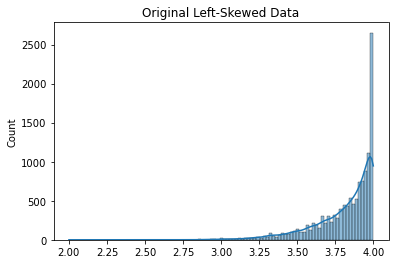

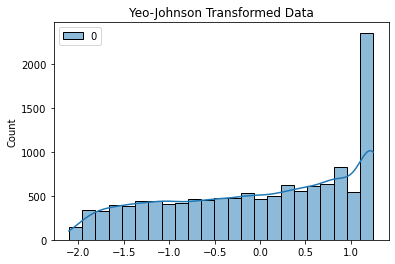

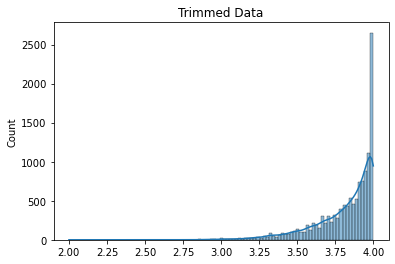

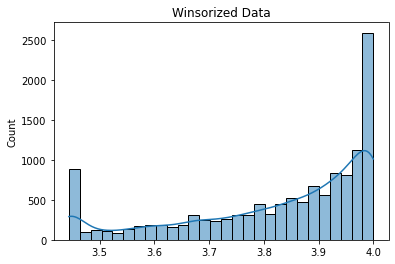

In [277]:
data = pd.read_excel("dat5.xlsx")
column_data = data['year_2_gpa']

# Convert the column to a numpy array
data = column_data.to_numpy()

# Original data
sns.histplot(data, kde=True)
plt.title('Original Left-Skewed Data')
plt.show()

# Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')
yeo_johnson_data = pt.fit_transform(data.reshape(-1, 1))

sns.histplot(yeo_johnson_data, kde=True)
plt.title('Yeo-Johnson Transformed Data')
plt.show()

# Trimming data (removing extreme 5% on each side)
trimmed_data = stats.trim1(data, proportiontocut=0.05)

sns.histplot(trimmed_data, kde=True)
plt.title('Trimmed Data')
plt.show()

# Winsorizing data (setting extreme values to the 5th and 95th percentiles)
winsorized_data = stats.mstats.winsorize(data, limits=[0.05, 0.05])

sns.histplot(winsorized_data, kde=True)
plt.title('Winsorized Data')
plt.show()


# GPA: Linear regression

## First year GPA

In [278]:
import pandas as pd
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat5.xlsx")
df = df.dropna(subset=['year_1_gpa'])
df = df.drop(columns=['Dept_code'])

# Convert year_1_gpa to numeric
df['year_1_gpa'] = pd.to_numeric(df['year_1_gpa'], errors='coerce')

# Create dummy variables
df = pd.get_dummies(df, columns=['Dept', 'ADMIT_TERM'], drop_first=True)

# Define X and y
X = df[['st_required'] + list(df.columns[df.columns.str.startswith('Dept_')]) + list(df.columns[df.columns.str.startswith('ADMIT_TERM_')])]
y = df['year_1_gpa']

# Convert st_required to numeric
X['st_required'] = pd.to_numeric(X['st_required'], errors='coerce')

# Ensure all dummy variables are numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Add constant to X
X = sm.add_constant(X)

# Check for any remaining non-numeric columns
print(X.dtypes)
print(y.dtypes)

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())


/var/folders/cp/yvxc2mxs2bqgmwd6cm4_cwsc0000gn/T/ipykernel_831/3632096320.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gre_required'] = pd.to_numeric(X['gre_required'], errors='coerce')
/var/folders/cp/yvxc2mxs2bqgmwd6cm4_cwsc0000gn/T/ipykernel_831/3632096320.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


const                       float64
gre_required                  int64
Dept_Applied Linguistics      uint8
Dept_Archaeology              uint8
Dept_Architecture             uint8
                             ...   
ADMIT_TERM_X17                uint8
ADMIT_TERM_X18                uint8
ADMIT_TERM_X19                uint8
ADMIT_TERM_X20                uint8
ADMIT_TERM_X21                uint8
Length: 148, dtype: object
float64
                            OLS Regression Results                            
Dep. Variable:             year_1_gpa   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     19.94
Date:                Thu, 11 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:46:58   Log-Likelihood:                 2671.8
No. Observations:               15688   AIC:                            -5048.
Df Residuals:   

## Second year GPA

In [279]:
import pandas as pd
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat5.xlsx")
df = df.dropna(subset=['year_2_gpa'])
df = df.drop(columns=['Dept_code'])

# Convert year_1_gpa to numeric
df['year_2_gpa'] = pd.to_numeric(df['year_2_gpa'], errors='coerce')

# Create dummy variables
df = pd.get_dummies(df, columns=['Dept', 'ADMIT_TERM'], drop_first=True)

# Define X and y
X = df[['st_required'] + list(df.columns[df.columns.str.startswith('Dept_')]) + list(df.columns[df.columns.str.startswith('ADMIT_TERM_')])]
y = df['year_2_gpa']

# Convert st_required to numeric
X['st_required'] = pd.to_numeric(X['st_required'], errors='coerce')

# Ensure all dummy variables are numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Add constant to X
X = sm.add_constant(X)

# Check for any remaining non-numeric columns
print(X.dtypes)
print(y.dtypes)

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())




/var/folders/cp/yvxc2mxs2bqgmwd6cm4_cwsc0000gn/T/ipykernel_831/1166618272.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gre_required'] = pd.to_numeric(X['gre_required'], errors='coerce')
/var/folders/cp/yvxc2mxs2bqgmwd6cm4_cwsc0000gn/T/ipykernel_831/1166618272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


const                       float64
gre_required                  int64
Dept_Applied Linguistics      uint8
Dept_Archaeology              uint8
Dept_Architecture             uint8
                             ...   
ADMIT_TERM_X17                uint8
ADMIT_TERM_X18                uint8
ADMIT_TERM_X19                uint8
ADMIT_TERM_X20                uint8
ADMIT_TERM_X21                uint8
Length: 145, dtype: object
float64
                            OLS Regression Results                            
Dep. Variable:             year_2_gpa   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     18.03
Date:                Thu, 11 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:47:07   Log-Likelihood:                 3588.2
No. Observations:               12833   AIC:                            -6886.
Df Residuals:   

# Program Separation: Logistic Regression

## First year separation

In [280]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat5.xlsx")
df = df.dropna(subset=['separated_1'])
df = df.drop(columns=['Dept_code'])

# Define dependent variable y
y = df['separated_1']

# Initialize X and add fixed effects for 'Dept' and 'ADMIT_TERM'
X = df[['st_required']]
X = pd.concat([X, pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ADMIT_TERM'], prefix='ADMIT_TERM', drop_first=True)], axis=1)

# Ensure all dummy variables are numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Add constant to X
X = sm.add_constant(X)

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()


## Calculate marginal effects

# Retrieve coefficients from the fitted model
coefficients = result.params

# Calculate linear predictor (XB)
lin_pred = np.dot(X.drop(columns=['const']), coefficients[1:]) + result.params['const']

# Calculate predicted probabilities using the logistic function
predicted_probs = 1 / (1 + np.exp(-lin_pred))

# Calculate marginal effects for each variable
marginal_effects = []

for i, coef in enumerate(coefficients[1:]):  # Exclude Intercept
    marginal_effect = coef * predicted_probs * (1 - predicted_probs)
    marginal_effects.append(marginal_effect)

# Include intercept effect (if needed)
intercept_effect = result.params['const'] * predicted_probs * (1 - predicted_probs)
marginal_effects.append(intercept_effect)

# Convert to numpy array for easier manipulation
marginal_effects = np.array(marginal_effects)
average_marginal_effect_st_required = np.mean(marginal_effects[1])

# Print marginal effects
print(f"Average marginal effects for 'st_required': {average_marginal_effect_st_required}")

# Output p-value for the coefficient of `st_required`
p_value_st_required = result.pvalues['st_required']
print(f"P-value for 'st_required': {p_value_st_required}")


# Output result summary
print("")
print(result.summary())

Average marginal effects for 'gre_required': -6.486116791383242e-06
P-value for 'gre_required': 0.999636910894242

                 Generalized Linear Model Regression Results                  
Dep. Variable:            separated_1   No. Observations:                15735
Model:                            GLM   Df Residuals:                    15587
Model Family:                Binomial   Df Model:                          147
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.313
Date:                Thu, 11 Jul 2024   Deviance:                       178.63
Time:                        21:47:15   Pearson chi2:                 2.21e+03
No. Iterations:                    29   Pseudo R-squ. (CS):           0.006410
Covariance Type:            nonrobust                                         
                                                                                     coef    st

## Second year separation

In [281]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat5.xlsx")
df = df.dropna(subset=['separated_2'])
df = df.drop(columns=['Dept_code'])

# Define dependent variable y
y = df['separated_2']

# Initialize X and add fixed effects for 'Dept' and 'ADMIT_TERM'
X = df[['st_required']]
X = pd.concat([X, pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ADMIT_TERM'], prefix='ADMIT_TERM', drop_first=True)], axis=1)

# Ensure all dummy variables are numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Add constant to X
X = sm.add_constant(X)

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()


## Calculate marginal effects

# Retrieve coefficients from the fitted model
coefficients = result.params

# Calculate linear predictor (XB)
lin_pred = np.dot(X.drop(columns=['const']), coefficients[1:]) + result.params['const']

# Calculate predicted probabilities using the logistic function
predicted_probs = 1 / (1 + np.exp(-lin_pred))

# Calculate marginal effects for each variable
marginal_effects = []

for i, coef in enumerate(coefficients[1:]):  # Exclude Intercept
    marginal_effect = coef * predicted_probs * (1 - predicted_probs)
    marginal_effects.append(marginal_effect)

# Include intercept effect (if needed)
intercept_effect = result.params['const'] * predicted_probs * (1 - predicted_probs)
marginal_effects.append(intercept_effect)

# Convert to numpy array for easier manipulation
marginal_effects = np.array(marginal_effects)
average_marginal_effect_st_required = np.mean(marginal_effects[1])

# Print marginal effects
print(f"Average marginal effects for 'st_required': {average_marginal_effect_st_required}")

# Output p-value for the coefficient of `st_required`
p_value_st_required = result.pvalues['st_required']
print(f"P-value for 'st_required': {p_value_st_required}")


# Output result summary
print("")
print(result.summary())

Average marginal effects for 'gre_required': 0.015107158026634126
P-value for 'gre_required': 0.5075175605586371

                 Generalized Linear Model Regression Results                  
Dep. Variable:            separated_2   No. Observations:                12872
Model:                            GLM   Df Residuals:                    12727
Model Family:                Binomial   Df Model:                          144
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.215
Date:                Thu, 11 Jul 2024   Deviance:                       70.430
Time:                        21:47:20   Pearson chi2:                     472.
No. Iterations:                    29   Pseudo R-squ. (CS):           0.004936
Covariance Type:            nonrobust                                         
                                                                                     coef    std

# URG Identity: Logistic Regression

In [282]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat6.xlsx")
df = df.dropna(subset=['URM'])
df = df.drop(columns=['Dept_code'])

# Define dependent variable y
y = df['URM']

# Initialize X and add fixed effects for 'Dept' and 'ADMIT_TERM'
X = df[['st_required']]
X = pd.concat([X, pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ADMIT_TERM'], prefix='ADMIT_TERM', drop_first=True)], axis=1)

# Ensure all dummy variables are numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Add constant to X
X = sm.add_constant(X)

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()


## Calculate marginal effects

# Retrieve coefficients from the fitted model
coefficients = result.params

# Calculate linear predictor (XB)
lin_pred = np.dot(X.drop(columns=['const']), coefficients[1:]) + result.params['const']

# Calculate predicted probabilities using the logistic function
predicted_probs = 1 / (1 + np.exp(-lin_pred))

# Calculate marginal effects for each variable
marginal_effects = []

for i, coef in enumerate(coefficients[1:]):  # Exclude Intercept
    marginal_effect = coef * predicted_probs * (1 - predicted_probs)
    marginal_effects.append(marginal_effect)

# Include intercept effect (if needed)
intercept_effect = result.params['const'] * predicted_probs * (1 - predicted_probs)
marginal_effects.append(intercept_effect)

# Convert to numpy array for easier manipulation
marginal_effects = np.array(marginal_effects)
average_marginal_effect_st_required = np.mean(marginal_effects[1])

# Print marginal effects
print(f"Average marginal effects for 'st_required': {average_marginal_effect_st_required}")

# Output p-value for the coefficient of `st_required`
p_value_st_required = result.pvalues['st_required']
print(f"P-value for 'st_required': {p_value_st_required}")


# Output result summary
print("")
print(result.summary())

Average marginal effects for 'gre_required': -0.0658266374644187
P-value for 'gre_required': 0.001841563758861527

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    URM   No. Observations:                20540
Model:                            GLM   Df Residuals:                    20387
Model Family:                Binomial   Df Model:                          152
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7534.1
Date:                Thu, 11 Jul 2024   Deviance:                       15068.
Time:                        21:47:26   Pearson chi2:                 2.01e+04
No. Iterations:                    24   Pseudo R-squ. (CS):            0.08913
Covariance Type:            nonrobust                                         
                                                                                     coef    st

# Gender: Logistic Regression

In [283]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat6.xlsx")
df = df.dropna(subset=['Non_Male'])
df = df.drop(columns=['Dept_code'])

# Define dependent variable y
y = df['Non_Male']

# Initialize X and add fixed effects for 'Dept' and 'ADMIT_TERM'
X = df[['st_required']]
X = pd.concat([X, pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ADMIT_TERM'], prefix='ADMIT_TERM', drop_first=True)], axis=1)

# Ensure all dummy variables are numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Add constant to X
X = sm.add_constant(X)

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()


## Calculate marginal effects

# Retrieve coefficients from the fitted model
coefficients = result.params

# Calculate linear predictor (XB)
lin_pred = np.dot(X.drop(columns=['const']), coefficients[1:]) + result.params['const']

# Calculate predicted probabilities using the logistic function
predicted_probs = 1 / (1 + np.exp(-lin_pred))

# Calculate marginal effects for each variable
marginal_effects = []

for i, coef in enumerate(coefficients[1:]):  # Exclude Intercept
    marginal_effect = coef * predicted_probs * (1 - predicted_probs)
    marginal_effects.append(marginal_effect)

# Include intercept effect (if needed)
intercept_effect = result.params['const'] * predicted_probs * (1 - predicted_probs)
marginal_effects.append(intercept_effect)

# Convert to numpy array for easier manipulation
marginal_effects = np.array(marginal_effects)
average_marginal_effect_st_required = np.mean(marginal_effects[1])

# Print marginal effects
print(f"Average marginal effects for 'st_required': {average_marginal_effect_st_required}")

# Output p-value for the coefficient of `st_required`
p_value_st_required = result.pvalues['st_required']
print(f"P-value for 'st_required': {p_value_st_required}")


# Output result summary
print("")
print(result.summary())

Average marginal effects for 'gre_required': 0.11394736381658957
P-value for 'gre_required': 0.05601985243627313

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Non_Male   No. Observations:                20540
Model:                            GLM   Df Residuals:                    20387
Model Family:                Binomial   Df Model:                          152
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12220.
Date:                Thu, 11 Jul 2024   Deviance:                       24440.
Time:                        21:47:33   Pearson chi2:                 2.05e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.1702
Covariance Type:            nonrobust                                         
                                                                                     coef    std

# Previous Degree Hold: Logistic Regression

In [284]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_excel("dat6.xlsx")
df = df.dropna(subset=['prev_deg'])
df = df.drop(columns=['Dept_code'])

# Define dependent variable y
y = df['prev_deg']

# Initialize X and add fixed effects for 'Dept' and 'ADMIT_TERM'
X = df[['st_required']]
X = pd.concat([X, pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(df['ADMIT_TERM'], prefix='ADMIT_TERM', drop_first=True)], axis=1)

# Ensure all dummy variables are numeric and handle missing values
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Drop rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]

# Add constant to X
X = sm.add_constant(X)

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()


## Calculate marginal effects

# Retrieve coefficients from the fitted model
coefficients = result.params

# Calculate linear predictor (XB)
lin_pred = np.dot(X.drop(columns=['const']), coefficients[1:]) + result.params['const']

# Calculate predicted probabilities using the logistic function
predicted_probs = 1 / (1 + np.exp(-lin_pred))

# Calculate marginal effects for each variable
marginal_effects = []

for i, coef in enumerate(coefficients[1:]):  # Exclude Intercept
    marginal_effect = coef * predicted_probs * (1 - predicted_probs)
    marginal_effects.append(marginal_effect)

# Include intercept effect (if needed)
intercept_effect = result.params['const'] * predicted_probs * (1 - predicted_probs)
marginal_effects.append(intercept_effect)

# Convert to numpy array for easier manipulation
marginal_effects = np.array(marginal_effects)
average_marginal_effect_st_required = np.mean(marginal_effects[1])

# Print marginal effects
print(f"Average marginal effects for 'st_required': {average_marginal_effect_st_required}")

# Output p-value for the coefficient of `st_required`
p_value_st_required = result.pvalues['st_required']
print(f"P-value for 'st_required': {p_value_st_required}")


# Output result summary
print("")
print(result.summary())

Average marginal effects for 'gre_required': 0.3341016949291302
P-value for 'gre_required': 0.05200504738826789

                 Generalized Linear Model Regression Results                  
Dep. Variable:               prev_deg   No. Observations:                17149
Model:                            GLM   Df Residuals:                    17026
Model Family:                Binomial   Df Model:                          122
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9765.2
Date:                Thu, 11 Jul 2024   Deviance:                       19530.
Time:                        21:47:40   Pearson chi2:                 1.71e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.1602
Covariance Type:            nonrobust                                         
                                                                                     coef    std 